# Codigo base

In [1]:
source("utils.r")

# Cargar datos

In [2]:
# Example of how to call the function
url <- "https://github.com/mbarrena/tesis/raw/refs/heads/main/data/Data%20trimestral%201950%20a%202023%20con%20DUMMIES%20outliers%20(por%20trimestre).xlsx"
temp_file <- tempfile(fileext = ".xlsx")
GET(url, write_disk(temp_file, overwrite = TRUE))

# Read the `data` from the Excel file
df_trimestral_crudo <- read_excel(temp_file)

Response [https://raw.githubusercontent.com/mbarrena/tesis/refs/heads/main/data/Data%20trimestral%201950%20a%202023%20con%20DUMMIES%20outliers%20(por%20trimestre).xlsx]
  Date: 2025-03-23 23:19
  Status: 200
  Content-Type: application/octet-stream
  Size: 57.9 kB
<ON DISK>  /var/folders/59/6k0yx0n916gg1mdb04zs42rm0000gn/T//RtmplA5PAG/filea4e16052010d.xlsxNULL

In [3]:
# Select specific columns and rows from df_trimestral_crudo
df_Arg <- df_trimestral_crudo |> 
  dplyr::slice(37:dplyr::n()) |>  # Equivalent to iloc[36:] (1-based index in R)
  dplyr::select(año, trimestre, ipc_ajust, E, Ebc, pbird, impp_usa, Psoja_USA, Pmaíz_USA, Ptrigo_USA, TOTfmi) |>  # nolint
  as.data.frame()  # Convert to data frame (if needed)

# Rename "ipc_ajust" to "ipc"
df_Arg <- renameColumnOfDataframe(df_Arg, "ipc_ajust", "ipc")

# Display first 6 rows
print(head(df_Arg))

# Display first 65 rows
print(head(df_Arg, 65))

   año trimestre          ipc            E          Ebc  pbird impp_usa
1 1959      1ºTr 2.413144e-11 6.690000e-12 6.669333e-12 177276 13.23729
2 1959      2ºTr 3.074744e-11 8.556667e-12 8.317000e-12 182783 13.25134
3 1959      3ºTr 3.511185e-11 8.408333e-12 8.414333e-12 166259 13.27944
4 1959      4ºTr 3.704045e-11 8.313333e-12 8.275667e-12 178163 13.47618
5 1960      1ºTr 3.935256e-11 8.293333e-12 8.297333e-12 186316 13.50428
6 1960      2ºTr 3.948672e-11 8.300000e-12 8.313000e-12 187541 13.51833
  Psoja_USA Pmaíz_USA Ptrigo_USA TOTfmi
1  2.046667 1.0433333   1.736667     NA
2  2.106667 1.1500000   1.743333     NA
3  1.976667 1.1166667   1.723333     NA
4  1.970000 0.9856667   1.780000     NA
5  1.996667 1.0096667   1.800000     NA
6  1.996667 1.0766667   1.786667     NA
    año trimestre          ipc            E          Ebc  pbird impp_usa
1  1959      1ºTr 2.413144e-11 6.690000e-12 6.669333e-12 177276 13.23729
2  1959      2ºTr 3.074744e-11 8.556667e-12 8.317000e-12 182783 13.251

In [4]:
# Copy df_Arg to df_ERPT_Arg1
df_ERPT_Arg1 <- df_Arg

# Display first rows
print(head(df_ERPT_Arg1))

# Apply logarithm to specific columns
df_ERPT_Arg1 <- makeLogColumns(c("ipc", "E", "Ebc", "pbird", "impp_usa", "Psoja_USA", "Pmaíz_USA", "Ptrigo_USA", "TOTfmi"), df_ERPT_Arg1) # nolint: line_length_linter.

# Display transformed dataframe
print(head(df_ERPT_Arg1))
print(tail(df_ERPT_Arg1))

   año trimestre          ipc            E          Ebc  pbird impp_usa
1 1959      1ºTr 2.413144e-11 6.690000e-12 6.669333e-12 177276 13.23729
2 1959      2ºTr 3.074744e-11 8.556667e-12 8.317000e-12 182783 13.25134
3 1959      3ºTr 3.511185e-11 8.408333e-12 8.414333e-12 166259 13.27944
4 1959      4ºTr 3.704045e-11 8.313333e-12 8.275667e-12 178163 13.47618
5 1960      1ºTr 3.935256e-11 8.293333e-12 8.297333e-12 186316 13.50428
6 1960      2ºTr 3.948672e-11 8.300000e-12 8.313000e-12 187541 13.51833
  Psoja_USA Pmaíz_USA Ptrigo_USA TOTfmi
1  2.046667 1.0433333   1.736667     NA
2  2.106667 1.1500000   1.743333     NA
3  1.976667 1.1166667   1.723333     NA
4  1.970000 0.9856667   1.780000     NA
5  1.996667 1.0096667   1.800000     NA
6  1.996667 1.0766667   1.786667     NA
   año trimestre       ipc         E       Ebc    pbird impp_usa Psoja_USA
1 1959      1ºTr -24.44751 -25.73041 -25.73350 12.08546 2.583038 0.7162125
2 1959      2ºTr -24.20521 -25.48431 -25.51272 12.11605 2.584099 0

In [5]:
# Create df_ERPT_Arg as a copy of df_Arg
df_ERPT_Arg <- df_Arg

# Display first rows
print(head(df_ERPT_Arg))

# Apply logarithm transformation
df_ERPT_Arg <- makeLogColumns(c("ipc", "E", "Ebc", "pbird", "impp_usa", "Psoja_USA", "Pmaíz_USA", "Ptrigo_USA", "TOTfmi"), df_ERPT_Arg)

# Display transformed dataframe
print(head(df_ERPT_Arg))

# Apply differencing transformation
df_ERPT_Arg <- makeDiffColumns(c("ipc", "E", "Ebc", "pbird", "impp_usa", "Psoja_USA", "Pmaíz_USA", "Ptrigo_USA", "TOTfmi"), df_ERPT_Arg)

# Display first and last rows
print(head(df_ERPT_Arg))
print(tail(df_ERPT_Arg, 90))

   año trimestre          ipc            E          Ebc  pbird impp_usa
1 1959      1ºTr 2.413144e-11 6.690000e-12 6.669333e-12 177276 13.23729
2 1959      2ºTr 3.074744e-11 8.556667e-12 8.317000e-12 182783 13.25134
3 1959      3ºTr 3.511185e-11 8.408333e-12 8.414333e-12 166259 13.27944
4 1959      4ºTr 3.704045e-11 8.313333e-12 8.275667e-12 178163 13.47618
5 1960      1ºTr 3.935256e-11 8.293333e-12 8.297333e-12 186316 13.50428
6 1960      2ºTr 3.948672e-11 8.300000e-12 8.313000e-12 187541 13.51833
  Psoja_USA Pmaíz_USA Ptrigo_USA TOTfmi
1  2.046667 1.0433333   1.736667     NA
2  2.106667 1.1500000   1.743333     NA
3  1.976667 1.1166667   1.723333     NA
4  1.970000 0.9856667   1.780000     NA
5  1.996667 1.0096667   1.800000     NA
6  1.996667 1.0766667   1.786667     NA
   año trimestre       ipc         E       Ebc    pbird impp_usa Psoja_USA
1 1959      1ºTr -24.44751 -25.73041 -25.73350 12.08546 2.583038 0.7162125
2 1959      2ºTr -24.20521 -25.48431 -25.51272 12.11605 2.584099 0

# Regresiones

[1] "LocalProjection (without exog) - signif 0.95"
    impulse response horizon  irf_value lower_bound upper_bound
1  impp_usa        E       1 -1.5446308  -1.5446308  -1.5446308
2  impp_usa        E       2 -0.4235005  -1.6739994   0.8269984
3  impp_usa        E       3  0.3351997  -0.7774561   1.4478554
4  impp_usa        E       4 -0.6853284  -1.3169637  -0.0536931
5  impp_usa        E       5  0.7874616  -0.4796184   2.0545416
6  impp_usa        E       6  1.3697783   0.2540676   2.4854889
7  impp_usa        E       7  0.6131873  -0.3932390   1.6196136
8  impp_usa        E       8  1.3673612   0.2385035   2.4962189
9  impp_usa        E       9  1.6757367   0.5200625   2.8314110
10 impp_usa        E      10  0.7925810   0.1288639   1.4562981
11 impp_usa        E      11  1.1532893   0.2139356   2.0926429
   impulse response horizon   irf_value lower_bound upper_bound
78     ipc        E       1  0.00000000  0.00000000  0.00000000
79     ipc        E       2 -0.36580988 -0.81207174  

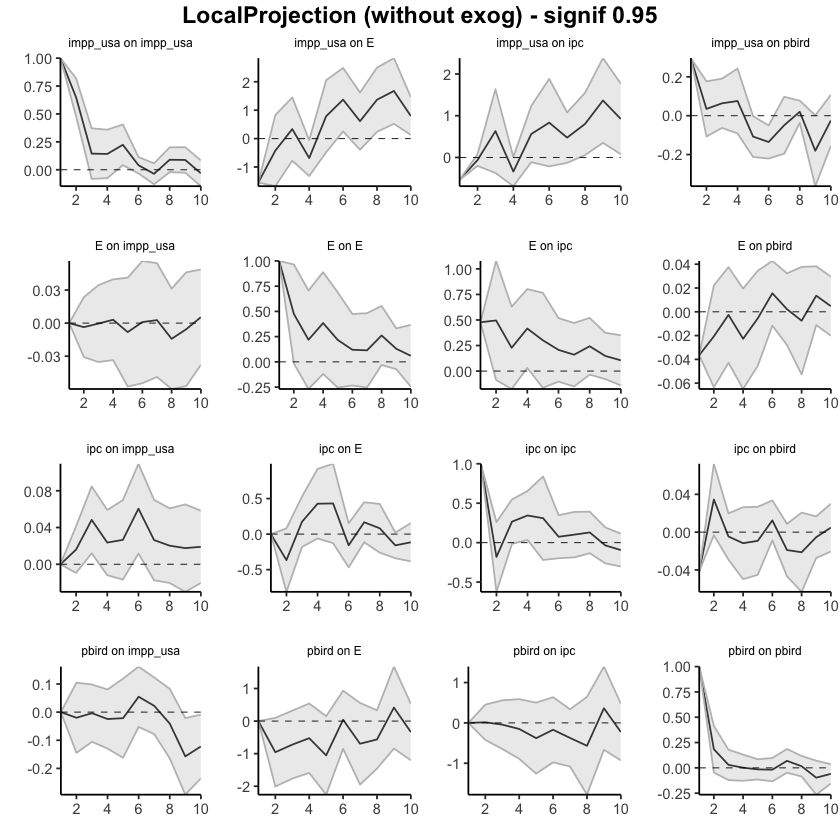

In [15]:
res <- run_lp_model(df_ERPT_Arg, endog=c("impp_usa", "E", "ipc", "pbird"), max_lags = 3, horizons=10, signif = 0.95)

[1] "LocalProjection (with exog) - signif 0.95"
   impulse response horizon   irf_value lower_bound upper_bound
23     ipc        E       1  0.00000000  0.00000000  0.00000000
24     ipc        E       2 -0.37009325 -0.79228778  0.05210129
25     ipc        E       3  0.17010576 -0.15969957  0.49991109
26     ipc        E       4  0.42525623 -0.02379667  0.87430913
27     ipc        E       5  0.42662959 -0.13704435  0.99030353
28     ipc        E       6 -0.15732090 -0.49974786  0.18510607
29     ipc        E       7  0.16373951 -0.15548121  0.48296023
30     ipc        E       8  0.07922268 -0.29699831  0.45544368
31     ipc        E       9 -0.15646354 -0.39660486  0.08367778
32     ipc        E      10 -0.11641602 -0.40454450  0.17171246
33     ipc        E      11 -0.08064676 -0.41541555  0.25412203
   impulse response horizon   irf_value lower_bound upper_bound
45   pbird        E       1  0.00000000   0.0000000   0.0000000
46   pbird        E       2 -0.95580422  -2.0520550   0.

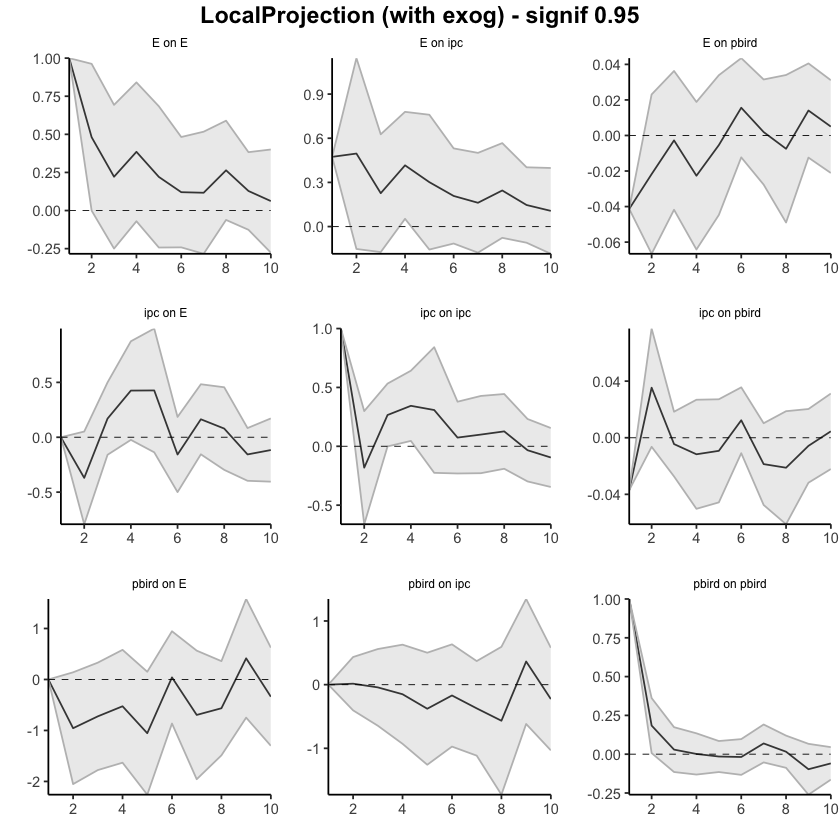

In [7]:
res <- run_lp_model(df_ERPT_Arg, endog=c("E", "ipc", "pbird"), exog=c("impp_usa"), max_lags = 3, newey_lags = 4, signif = 0.95)

[1] "LocalProjection (with exog) - Cumulative - signif 0.95"
   impulse response horizon  irf_value lower_bound upper_bound
23     ipc        E       1  0.0000000   0.0000000  0.00000000
24     ipc        E       2 -0.3700932  -0.7922878  0.05210129
25     ipc        E       3 -0.1999875  -0.9519873  0.55201238
26     ipc        E       4  0.2252687  -0.9757840  1.42632151
27     ipc        E       5  0.6518983  -1.1128284  2.41662505
28     ipc        E       6  0.4945774  -1.6125762  2.60173112
29     ipc        E       7  0.6583170  -1.7680574  3.08469135
30     ipc        E       8  0.7375396  -2.0650557  3.54013502
31     ipc        E       9  0.5810761  -2.4616606  3.62381280
32     ipc        E      10  0.4646601  -2.8662051  3.79552526
33     ipc        E      11  0.3840133  -3.2816207  4.04964728
   impulse response horizon  irf_value lower_bound upper_bound
45   pbird        E       1  0.0000000    0.000000   0.0000000
46   pbird        E       2 -0.9558042   -2.052055   0.14

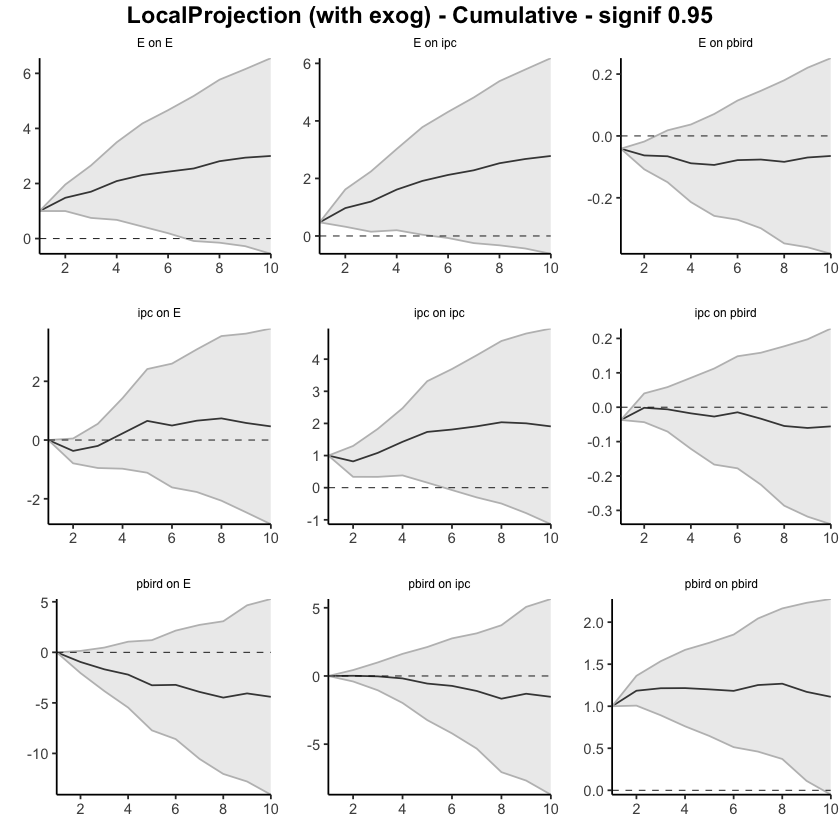

In [8]:
res <- run_lp_model(df_ERPT_Arg, endog=c("E", "ipc", "pbird"), exog=c("impp_usa"), max_lags = 3, newey_lags = 4, signif = 0.95, cumulative=TRUE)
#run_lp_model(df_ERPT_Arg, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, newey_lags = 4, signif = 0.68)
#run_lp_model(df_ERPT_Arg, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, signif = 0.95)
#run_lp_model(df_ERPT_Arg, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, signif = 0.68)
#run_lp_model(df_ERPT_Arg, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, newey_lags = 4, signif = 0.95)
#run_lp_model(df_ERPT_Arg, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, newey_lags = 4, signif = 0.68)
#run_lp_model(df_ERPT_Arg, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, signif = 0.95)
#run_lp_model(df_ERPT_Arg, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, signif = 0.68)

[1] "LocalProjection (with exog) - signif 0.68"
   impulse response horizon   irf_value  lower_bound  upper_bound
23     ipc        E       1  0.00000000  0.000000000  0.000000000
24     ipc        E       2 -0.34671181 -0.546761485 -0.146662140
25     ipc        E       3  0.27792655  0.130551050  0.425302054
26     ipc        E       4  0.43894962  0.174195584  0.703703665
27     ipc        E       5  0.37041306  0.082472778  0.658353345
28     ipc        E       6 -0.17634858 -0.346519486 -0.006177684
29     ipc        E       7  0.16487035 -0.006069757  0.335810458
30     ipc        E       8  0.05116697 -0.116215773  0.218549714
31     ipc        E       9 -0.19991464 -0.316807438 -0.083021834
32     ipc        E      10 -0.12615000 -0.294123615  0.041823612
33     ipc        E      11 -0.05668582 -0.278152999  0.164781352
   impulse response horizon  irf_value lower_bound upper_bound
45   pbird        E       1  0.0000000  0.00000000  0.00000000
46   pbird        E       2 -0.583

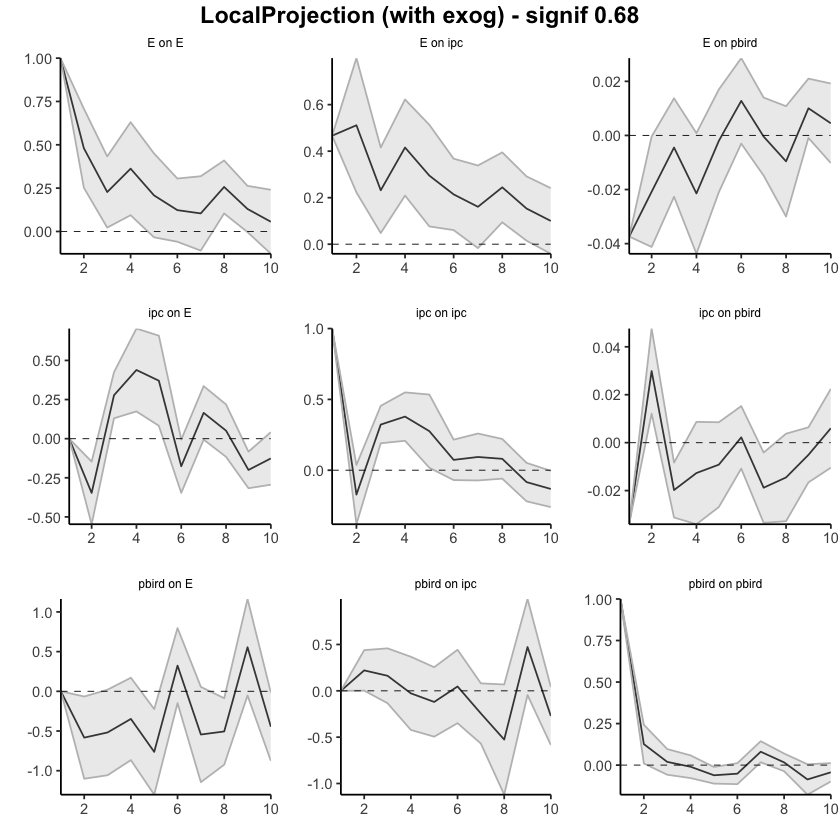

In [9]:
res <- run_lp_model(df_ERPT_Arg, endog=c("E", "ipc", "pbird"), exog=c("impp_usa"), max_lags = 5, signif = 0.68)

[1] "LocalProjection (with exog) - Cumulative - signif 0.68"
   impulse response horizon   irf_value lower_bound upper_bound
23     ipc        E       1  0.00000000   0.0000000   0.0000000
24     ipc        E       2 -0.34671181  -0.5467615  -0.1466621
25     ipc        E       3 -0.06878526  -0.4162104   0.2786399
26     ipc        E       4  0.37016436  -0.2420149   0.9823436
27     ipc        E       5  0.74057742  -0.1595421   1.6406969
28     ipc        E       6  0.56422884  -0.5060616   1.6345192
29     ipc        E       7  0.72909919  -0.5121313   1.9703297
30     ipc        E       8  0.78026616  -0.6283471   2.1888794
31     ipc        E       9  0.58035153  -0.9451545   2.1058576
32     ipc        E      10  0.45420152  -1.2392781   2.1476812
33     ipc        E      11  0.39751570  -1.5174311   2.3124625
   impulse response horizon  irf_value lower_bound upper_bound
45   pbird        E       1  0.0000000    0.000000  0.00000000
46   pbird        E       2 -0.5833729   -1.1

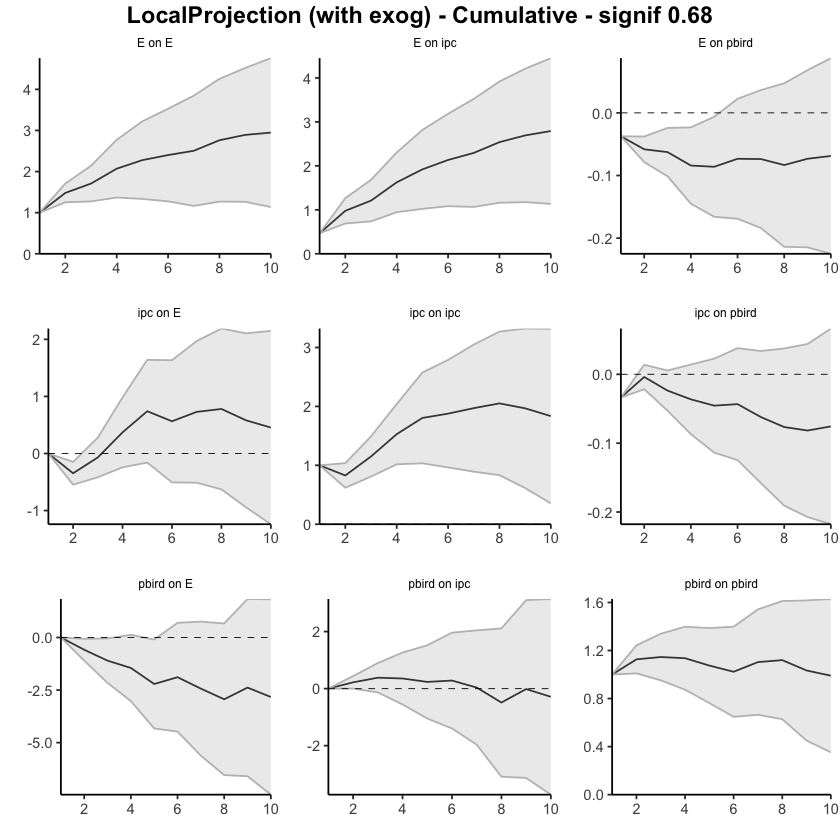

In [10]:
res <- run_lp_model(df_ERPT_Arg, endog=c("E", "ipc", "pbird"), exog=c("impp_usa"), max_lags = 5, signif = 0.68, cumulative=TRUE)